# Analítica de datos
# Examen parcial 1
# 2020-01
# <font color='red'> Steven Bernal, A00021016 </font>

El dataset que deben analizar contiene los registros del histórico de las personas a las que se les ha otorgado un crédito financiero, indicando quienes pudieron pagarlo sin problemas y quienes no.

La idea es poder predecir, utilizando modelos de aprendizaje supervisado (KNN y Naïve Bayes) y las variables independientes disponibles qué aspirantes a un crédito tienen mas o menos riesgo de pagar.

Las variables de la hoja de datos son las siguientes:
- ID: El ID único del cliente en el banco. Variable numérica positiva. 
- PudoPagar: Indica si el cliente ha podido pagar el crédito sin problemas (1) o no (0). Variable categórica binaria.
- Estudiante: Indica si el cliente es estudiante (Si) o no lo es (No). Variable categórica binaria.
- Deuda: Indica la cantidad de dinero que aún adeuda el cliente correspondiente a préstamos. Valores numéricos positivos o en cero.
- Cuenta: Indica el dinero que tiene en la cuenta del banco. Valores numéricos. Estas cuentas no permiten tener saldo en rojo.

¿Que es saldo en rojo?

## Entendimiento de los datos, limpieza

El archivo "creditos_examen.csv" contiene el dataset que tienen que analizar.
Se recomienda abrirlo primero en un lector de archivos planos para entender preliminarmente su formato y así poderlo cargar adecuadamente con Python.

Teniendo en cuenta el tipo de problema en cuestión (clasificación o regresión), realice un análisis exploratorio de los datos estableciendo el baseline, verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

#### Puntos a desarrollar

- <font color='red'>1. Limpieza de datos: Exploren los datos e identifiquen problemas e inconsistencias del dataset teniendo en cuenta el diccionario de datos y del contexto. Arreglen los problemas identificados (solo después de identificarlos todos), argumentando sus decisiones. (2.0)</font>
- <font color='red'>2. Obtengan el modelo de referencia (Baseline), interprételo y calcule su accuracy. (0.3)</font>

## Modelamiento con K-NN y Naïve Bayes

#### Puntos a desarrollar:

<font color='red'>Entrene modelos de clasificación siguiendo el siguiente protocolo:</font>
- <font color='red'>3. Haga un holdout estratificado 70% training - 30% test sobre el dataset solo incluyendo las variables numéricas. No olvide normalizar los datos correctamente (0.3)</font>
- <font color='red'>4. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo K-NN, teniendo en cuenta el Kappa. Evaluar un modelo global, otro para estudiantes y otro para no estudiantes. Concluir (0.9)</font>
- <font color='red'>5. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo NaïveBayes, tenga en cuenta utilizar las distribuciones adecuadas a los tipos de variables predictivas. Repetir el proceso de los tres modelos. (0.9) Si quisieramos incluir el efecto de la variable Estudiante en el modelo entrenado con las variables numéricas sin utilizar sklearn, que tenemos que hacer (0.2)</font>
- <font color='red'>6. Sobre el test set compare los dos modelos (K-NN y NB) y escoja el mejor según el Kappa (0.4)</font>

# Desarrollo de los puntos

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
#...
#...
#...

In [2]:
%matplotlib inline

## Exploracion de datos

In [3]:
dStud = pd.read_csv('creditos_examen.csv', sep=";")
dStud.tail()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
9997,9996,0,No,5299238,3557775
9998,9997,0,No,1966072,3789815
9999,9998,0,No,5863616,4227060
10000,9999,0,No,3666911,7845045
10001,10000,0,Si,1686295,1004611


In [4]:
dStud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 5 columns):
ID            10002 non-null int64
PudoPagar     10002 non-null int64
Estudiante    9998 non-null object
Deuda         10002 non-null int64
Cuenta        10002 non-null int64
dtypes: int64(4), object(1)
memory usage: 390.8+ KB


In [5]:
dStud.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,10002.000000,10002.000000,9998,1.000200e+04,1.000200e+04
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,7050,NaN,NaN
mean,5000.379324,0.033293,NaN,3.036624e+06,1.545269e+07
std,2887.127481,0.179410,NaN,7.028235e+07,1.019546e+09
min,-3.000000,0.000000,NaN,-4.288864e+09,-2.247063e+07
25%,2500.250000,0.000000,NaN,1.823657e+06,2.408188e+06
50%,5000.500000,0.000000,NaN,3.209805e+06,4.118185e+06
75%,7500.750000,0.000000,NaN,4.281461e+06,5.833152e+06


### Primer problema (Valores nulos)

#### Identificar cuantos valores son nulos

In [6]:
nul = dStud.notnull()
nul.all(axis=1).value_counts()

True     9998
False       4
dtype: int64

#### Identificar cuantos valores nulos hay por filas

In [7]:
dStud.notnull().apply(pd.Series.value_counts)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
False,NaN,NaN,4,NaN,NaN
True,10002.0,10002.0,9998,10002.0,10002.0


#### Cuales son los valores nulos

In [8]:
nul = ~dStud['Estudiante'].notnull()
dStud[nul]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
757,760,0,NaN,2538070,1924989
777,780,0,NaN,4119537,5096245
797,800,0,NaN,3377683,50944
817,820,0,NaN,2721295,474662


### Problema 2

In [9]:
dStud['Estudiante'].unique()

array(['No', 'Si', nan, '1', '0'], dtype=object)

In [10]:
dStud[(dStud['Estudiante'] == '0') | (dStud['Estudiante'] == '1')]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
4691,4692,0,1,1370247,1158854
6485,6486,0,1,2432606,4800570
6930,6930,0,0,4958587,1493598
7994,7994,0,0,3467996,1855909
7995,7995,0,1,1920050,7190277
8610,8609,0,0,4250341,4646486


### Problema 3

In [11]:
dStud['PudoPagar'].dtype

dtype('int64')

### Problema 4

In [12]:
saldoRojo = (dStud['Cuenta'] < 1)
dStud[saldoRojo].shape

(500, 5)

In [13]:
deudaRojo = (dStud['Deuda'] < 0)
dStud[deudaRojo].shape

(999, 5)

### Problema 5

In [14]:
dStud['ID'].unique()

array([    1,     2,     3, ...,  9998,  9999, 10000], dtype=int64)

### Problema 6

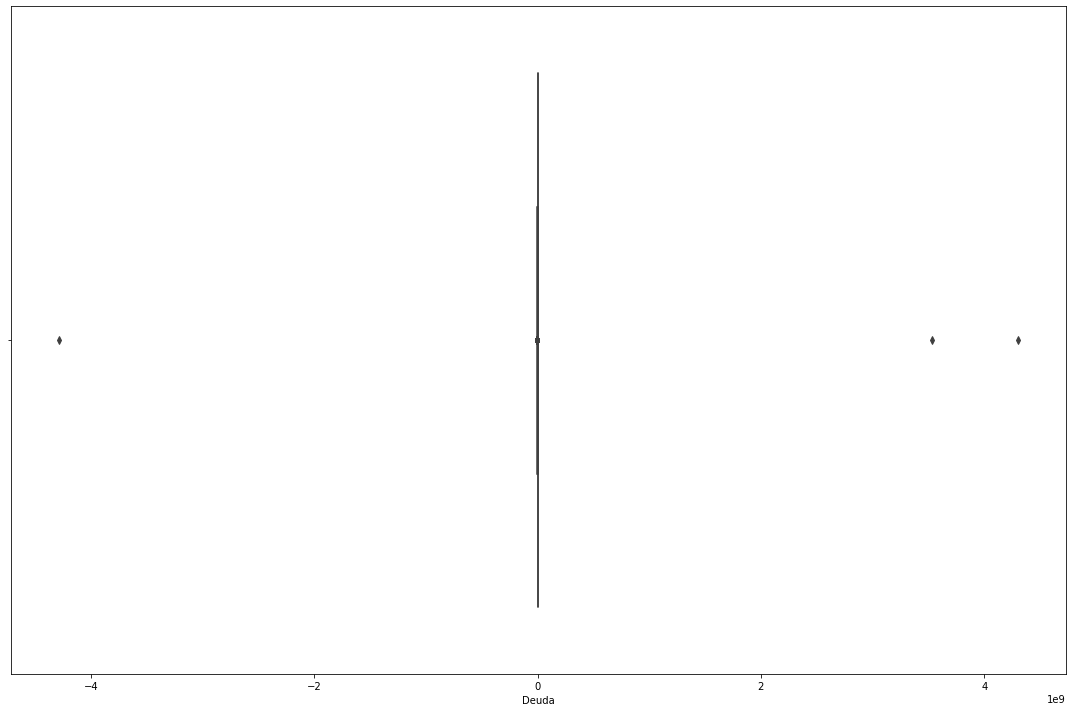

In [26]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
#plt.title(var_num)
sns.boxplot(x=dStud['Deuda'], data=dStud)
#ax.set_xticklabels(dStud.loc[:,'Deuda':'Cuenta'].unique())
fig.tight_layout()


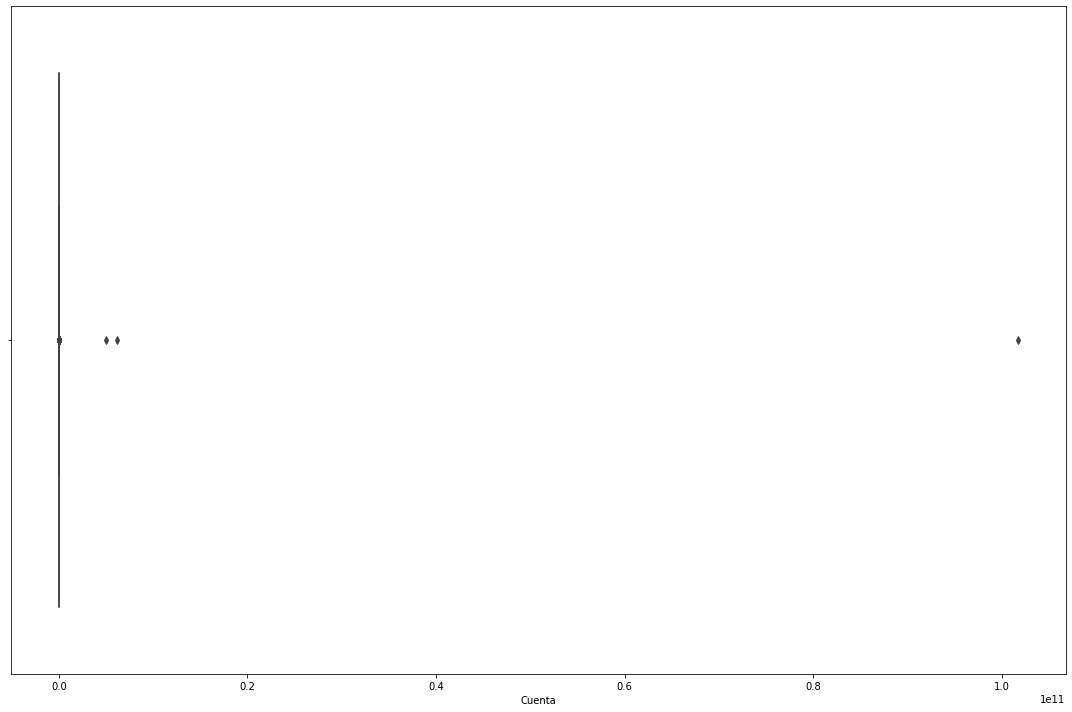

In [25]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
#plt.title(var_num)
sns.boxplot(x=dStud['Cuenta'], data=dStud)
#ax.set_xticklabels(dStud.loc[:,'Deuda':'Cuenta'].unique())
fig.tight_layout()


...

...

# 1. Limpieza de datos

## Identificación de problemas de datos.

...

...

...

Resumen de los problemas encontrados:
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]

## Corrección de problemas de datos.

...

...

...

Tenemos que el dataset después de limpieza cuenta con  XXXX registros.

# 2. Modelo de referencia (Baseline)

...

...

...

# 3. Holdout sobre el dataset

...

...

...

# 4. KNN

...

...

...

# 5. Naive Bayes

...

...

...

# 6. Comparación y conclusiones

...

...

...